### Analyzing a bike trip from Lyon to amsterdam 

We parse Strava gpx files and see what stats and plot we can make.

In [2]:
import gpxpy
import os
from pathlib import Path
from glob import glob
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
figsize_wide = figsize = [14,5]
import geopandas as gpd
from geopy import distance
from shapely.geometry import Point, Polygon

import sys
sys.path.insert(0, 'helper_functions/')
from gpx_parser import make_parser, print_gpx_info, make_parser

PATH = '/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/'
p = Path(PATH)
files = list(p.rglob('*.gpx*'))

In [3]:
# commodity function found at 
# https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

## stats

get statistics to check for one the tracks

In [4]:
f = open('/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/01_tape_1_Lyon_Albertville_.gpx', 'r')
gpx_file = gpxpy.parse(f)

args, gpx_files = make_parser().parse_known_args()
print_gpx_info(gpx = gpx_file,gpx_file='01_tape_1_Lyon_Albertville_.gpx')

File: 01_tape_1_Lyon_Albertville_.gpx
    Length 2D: 165.890km
    Length 3D: 166.034km
    Moving time: 07:22:29
    Stopped time: 00:37:28
    Max speed: 13.68m/s = 49.26km/h
    Avg speed: 6.25m/s = 22.51km/h
    Total uphill: 1887.68m
    Total downhill: 1751.28m
    Started: 2018-07-28 04:18:05
    Ended: 2018-07-28 12:18:02
    Points: 5823
    Avg distance between points: 28.49m

    Track #0, Segment #0
        Length 2D: 165.890km
        Length 3D: 166.034km
        Moving time: 07:22:29
        Stopped time: 00:37:28
        Max speed: 13.68m/s = 49.26km/h
        Avg speed: 6.25m/s = 22.51km/h
        Total uphill: 1887.68m
        Total downhill: 1751.28m
        Started: 2018-07-28 04:18:05
        Ended: 2018-07-28 12:18:02
        Points: 5823
        Avg distance between points: 28.49m



# load & analyze

In [5]:
def load_bike_data(gpx_files_path, filter=""):
    files = list(p.rglob('*.gpx*'))
    
    track_data = []
    
    for file_idx, file in enumerate(files): 
        try:
            gpx = gpxpy.parse(open(file, 'r'))
        except ValueError:
            print ('gpx files not loaded')
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            moving_time, stopped_time, moving_distance, stopped_distance, max_speed = track.get_moving_data()
            uphill, downhill = track.get_uphill_downhill()
            
            for i, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    track_data.append([file_idx, 
                                       track_name, 
                                       track_time, 
                                       track_length, 
                                       track_duration, 
                                       moving_time, stopped_time,moving_distance,stopped_distance,max_speed,
                                       uphill,downhill,
                                       i, 
                                       point.time, 
                                       point.latitude, 
                                       point.longitude, 
                                       point.elevation, 
                                       segment.get_speed(i)])
    return track_data

In [6]:
def create_dateparts_columns(df, datetime_col, date_fmt):
    """
    Convert string date column to datetime and add date, day, weekday and hour columns to dataframe
    INPUT:
     df: pandas df
     datetime_col: name column to be converted to datetime
     date_fmt: string format of datetime column
    RETURNS:
     dataframe with extra columns
    """
    df['point_time'] = pd.to_datetime(df[datetime_col], format = date_fmt)
    df = df.assign(date = lambda x: x[datetime_col].dt.date,
                   time = lambda x: x[datetime_col].dt.time,
                   day = lambda x: x[datetime_col].dt.day,
                   weekday = lambda x: x[datetime_col].dt.weekday,
                   hour = lambda x: x[datetime_col].dt.hour)
    return df

In [7]:
data = load_bike_data(gpx_files_path=PATH, filter="")
df = pd.DataFrame(data, columns=['file_index', 'etappe', 'time', 'length', 'duration', 'moving_time', 
                                 'stopped_time', 'moving_distance', 'stopped_distance','max_speed', 
                                 'uphill','downhill','segment_index', 'point_time', 
                                 'lat', 'lon', 'elev', 'speed'])
df = create_dateparts_columns(df, datetime_col='point_time', date_fmt='%Y-%m-%d %H:%M:%S')

In [35]:
def munge_gpx_dataframe(df, file_index):
    
    print ("parsing file_index= {}".format(file_index))
    df = df[df.file_index == file_index]
    df = df.sort_values(by = ['file_index', 'point_time'], ascending=[True, True])
    
    df = df.copy()
    df['max_speed'] = (df['max_speed'] *3600. / 1000.) # to km/h
    # new start_time column 
    df['start_time'] = 'no'
    df.loc[df.point_time == df.point_time.iloc[0], 'start_time'] = 'start_time'
    df.loc[df.point_time == df.point_time.iloc[-1], 'start_time'] = 'end_time'
    # duration to hours
    df['duration'] = (df['duration']/60./60.)
    # length to km 
    df['length'] = (df.length/1000.).map('{:.1f}km'.format)
    
    # get segment index
    df['segment_index'] = pd.Series(range(0, len(df)),dtype='int', index=df.index)
    
    # elev_change
    df['elev_change'] = df.elev.subtract(df.elev.shift())
    
    # time_diff
    df['time_diff'] = pd.to_timedelta(df['time'].astype(str)).diff()
    df['time_diff_s'] = df.time_diff.dt.seconds
    
    # calculate distance off every subsegment in track (df needs to be correctly ordered time-wise -asc)
    segment_dist_list_ = []
    for i in range(0, len(df.segment_index)):
        if i < range(0, len(df.segment_index))[-1]:
            (segment_dist_list_.append(
                distance.vincenty(
                 tuple((df.loc[(df.segment_index == i, ['lat', 'lon'])].values)
                       .reshape(1, -1)[0]),
                 tuple((df.loc[(df.segment_index == i + 1, ['lat', 'lon'])].values)
                       .reshape(1, -1)[0])
                ).m) # meters
            )
        else:
            segment_dist_list_.append(0)
    df['length_segment'] = pd.DataFrame(segment_dist_list_, index=df.index)
    
    # speed df km/h {:.2f}km/h
    df['speed_kmh'] = (df['length_segment']/1000).div((df['time_diff_s'] / 3600))
    df['speed_ms'] = (df['length_segment']).div((df['time_diff_s']))
    
    threshold = 0.66
    df['mov'] = np.where(df.speed_kmh <= threshold, 'stopping', 'moving')
    
    # length to km 
    df['moving_time'] = (df['moving_time']/60./60.).map('{:.2f}'.format)
    df['stopped_time'] = (df['stopped_time']/60./60.).map('{:.2f}'.format)
    df['moving_distance'] = (df['moving_distance']/1000).map('{:.1f}km'.format)
    df['stopped_distance'] = (df['stopped_distance']/1000).map('{:.1f}km'.format)
    
    return df

In [36]:
# oepss files where not ordered chronologically, the correct order of the etappes (file_list-wise) is:
file_index_order = [4, 7, 2, 3, 8, 6, 10, 9, 1, 5, 0, 11]
#file_index_order_test = [4,7]
appended_date = []
for file_ind in file_index_order:
    appended_date.append(munge_gpx_dataframe(df=df, file_index=file_ind))

parsing file_index= 4
parsing file_index= 7
parsing file_index= 2
parsing file_index= 3
parsing file_index= 8
parsing file_index= 6
parsing file_index= 10
parsing file_index= 9
parsing file_index= 1
parsing file_index= 5
parsing file_index= 0
parsing file_index= 11


In [166]:
# let's choose a speed threshold under which we will qualify as 'not moving'. We choose to end up as 
# closely as possible to Strava's registered 'Stopped time: 03:12:02'
#for threshold in list(np.linspace(0,2,10)):
#    print (test[(test.speed_kmh <= threshold)]['time_diff'].sum(), threshold)

In [37]:
df = pd.concat(appended_date)

In [38]:
# to csv in data folder
df.to_csv(PATH + 'munged_strava_data.csv', index=False)

In [4]:
df = pd.read_csv(PATH + 'munged_strava_data.csv')

# plots 

What's with the speed? 

In [5]:
# id the 10 largest speed_kmh records. ouch..
df.speed_kmh.nlargest(5)

8838     5426.196067
24553    5340.818570
25318    4011.846048
23753    3017.609458
24590    2290.454714
Name: speed_kmh, dtype: float64

In [141]:
# peak into rows with largest speed value
df.iloc[8836: 8840, :]

,file_index,etappe,time,length,duration,moving_time,stopped_time,moving_distance,stopped_distance,max_speed,uphill,downhill,segment_index,point_time,lat,lon,elev,speed,date,day,weekday,hour,start_time,elev_change,time_diff,time_diff_s,length_segment,speed_kmh,speed_ms,mov
8836,7,Étape 2# Albertville - Aoste,08:15:16,152.2km,9.110278,8.26,0.86,152.1km,0.1km,52.550427,3118.0,3126.4,3013,2018-07-29 08:15:16,45.662630,6.779736,1031.8,2.116159,2018-07-29,29,6,8,no,-0.8,0 days 00:00:01.000000000,1.0,0.000000,0.000000,0.000000,stopping
8837,7,Étape 2# Albertville - Aoste,08:15:17,152.2km,9.110278,8.26,0.86,152.1km,0.1km,52.550427,3118.0,3126.4,3014,2018-07-29 08:15:17,45.662630,6.779736,1029.6,2.116159,2018-07-29,29,6,8,no,-2.2,0 days 00:00:01.000000000,1.0,0.000000,0.000000,0.000000,stopping
8838,7,Étape 2# Albertville - Aoste,08:15:18,152.2km,9.110278,8.26,0.86,152.1km,0.1km,52.550427,3118.0,3126.4,3015,2018-07-29 08:15:18,45.662630,6.779736,1028.6,2.116159,2018-07-29,29,6,8,no,-1.0,0 days 00:00:01.000000000,1.0,1507.276685,5426.196067,1507.276685,moving
8839,7,Étape 2# Albertville - Aoste,08:15:20,152.2km,9.110278,8.26,0.86,152.1km,0.1km,52.550427,3118.0,3126.4,3016,2018-07-29 08:15:20,45.650186,6.787423,1026.4,2.116159,2018-07-29,29,6,8,no,-2.2,0 days 00:00:02.000000000,2.0,15.145657,27.262183,7.572829,moving


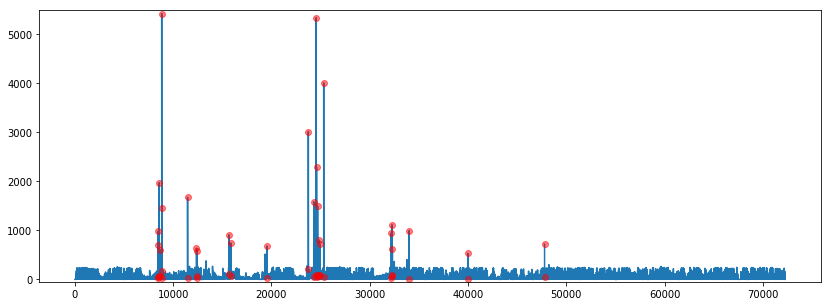

In [230]:
threshold = 250
kw = dict(marker='o', linestyle='none', color='r', alpha=0.5)

df['pandas'] = (df.query("mov == 'moving'").speed_kmh.rolling(window=2, center=True)
                .median().fillna(method='bfill').fillna(method='ffill'))

difference = np.abs(df['speed_kmh'] - df['pandas'])
outlier_idx = difference > threshold

fig, ax = plt.subplots(figsize=figsize_wide)
df['speed_kmh'].plot()
df['speed_kmh'][outlier_idx].plot(**kw)
_ = ax.set_ylim(-50, 5500)

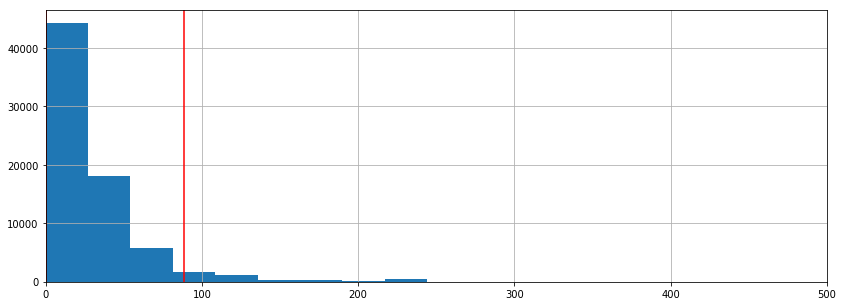

In [6]:
# 1) Quantile-based discretization function
_, bins = pd.qcut(df.speed_kmh, q=[0, .95], retbins=True)
ax = df.speed_kmh.hist(bins=200, figsize=figsize_wide)

for b in bins:
    ax.axvline(b, color='r')
_ = ax.set_xlim([0,500])

In [7]:
# skim off the extreme speed values
df = df[(df['speed_kmh'] > bins[0]) & (df['speed_kmh'] < bins[1])]

In [8]:
# still fast, but downhill who knows?
df.speed_kmh.max()

88.89164627973314

[Text(0.5,1,'Emperical Distribution')]

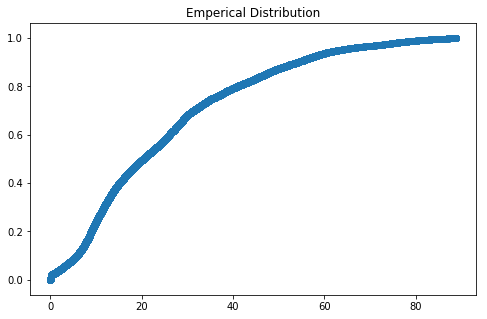

In [9]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

fig, ax = plt.subplots(figsize= [8,5])
x, y = ecdf(df['speed_kmh'])
ax.scatter(x,y)
ax.set(title = 'Emperical Distribution')

## check distribution after skimming off the extremes

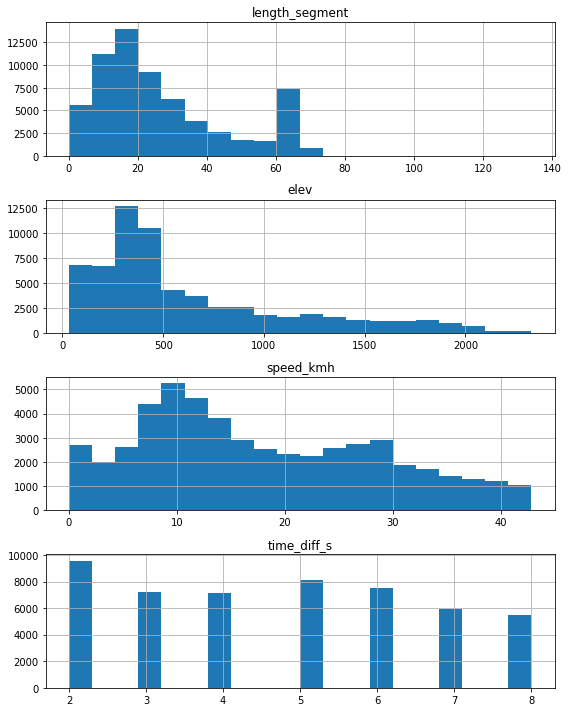

In [10]:
num_cols = ['length_segment', 'elev','speed_kmh', 'time_diff_s']
fig, ax = plt.subplots(len(num_cols), 1, figsize= [8,10])

for i, col in enumerate(df[num_cols].columns):
    if col == 'speed_kmh' or col== 'time_diff_s':
        reject_outliers(df[col].dropna()).hist(bins=20, ax=ax[i])
        ax[i].set_title(col)
    else:
        df[col].dropna().hist(bins=20, ax=ax[i])
        ax[i].set_title(col)
plt.tight_layout()

### plot downhill vs uphill over time

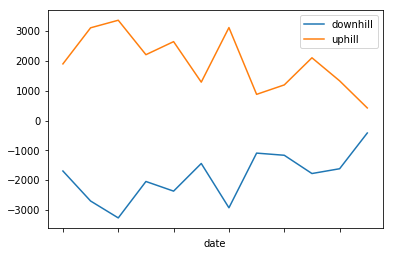

In [11]:
# this threshold seems not too bad as the up & downhill stats correspond pretty well with Strava's
(df.query("mov == 'moving'").groupby(['date'])['elev_change'].agg([('downhill' , lambda x : x[x <= 0].sum()) , 
                                           ('uphill' , lambda x : x[x >= 0].sum())])).plot()

### speed vs up/downhill on all tracks

In [12]:
df = df.set_index('point_time')

Text(0,0.5,'mean elevation ($m$)')

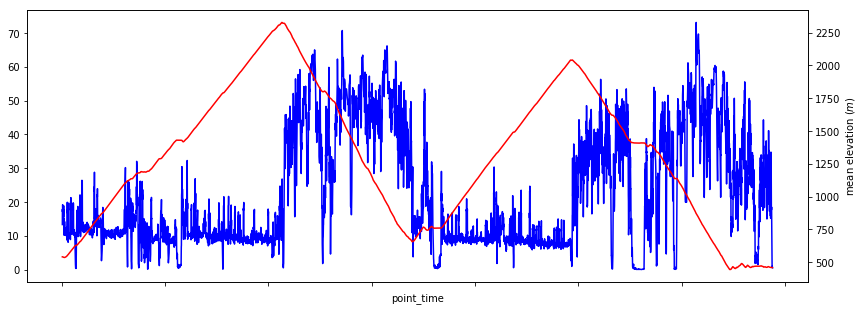

In [22]:
import matplotlib.dates as mdates
df_sub = df.query("date == '2018-07-30'")
h_fmt = mdates.DateFormatter('%H')

fig, ax = plt.subplots(figsize = figsize_wide)
df_sub.speed_kmh.rolling(window=5).mean().plot(ax=ax, color='blue')
ax2 = ax.twinx()
df_sub.elev.rolling(window=5).mean().plot(ax=ax2, color='red')
ax2.set_ylabel(r"mean elevation ($m$)")

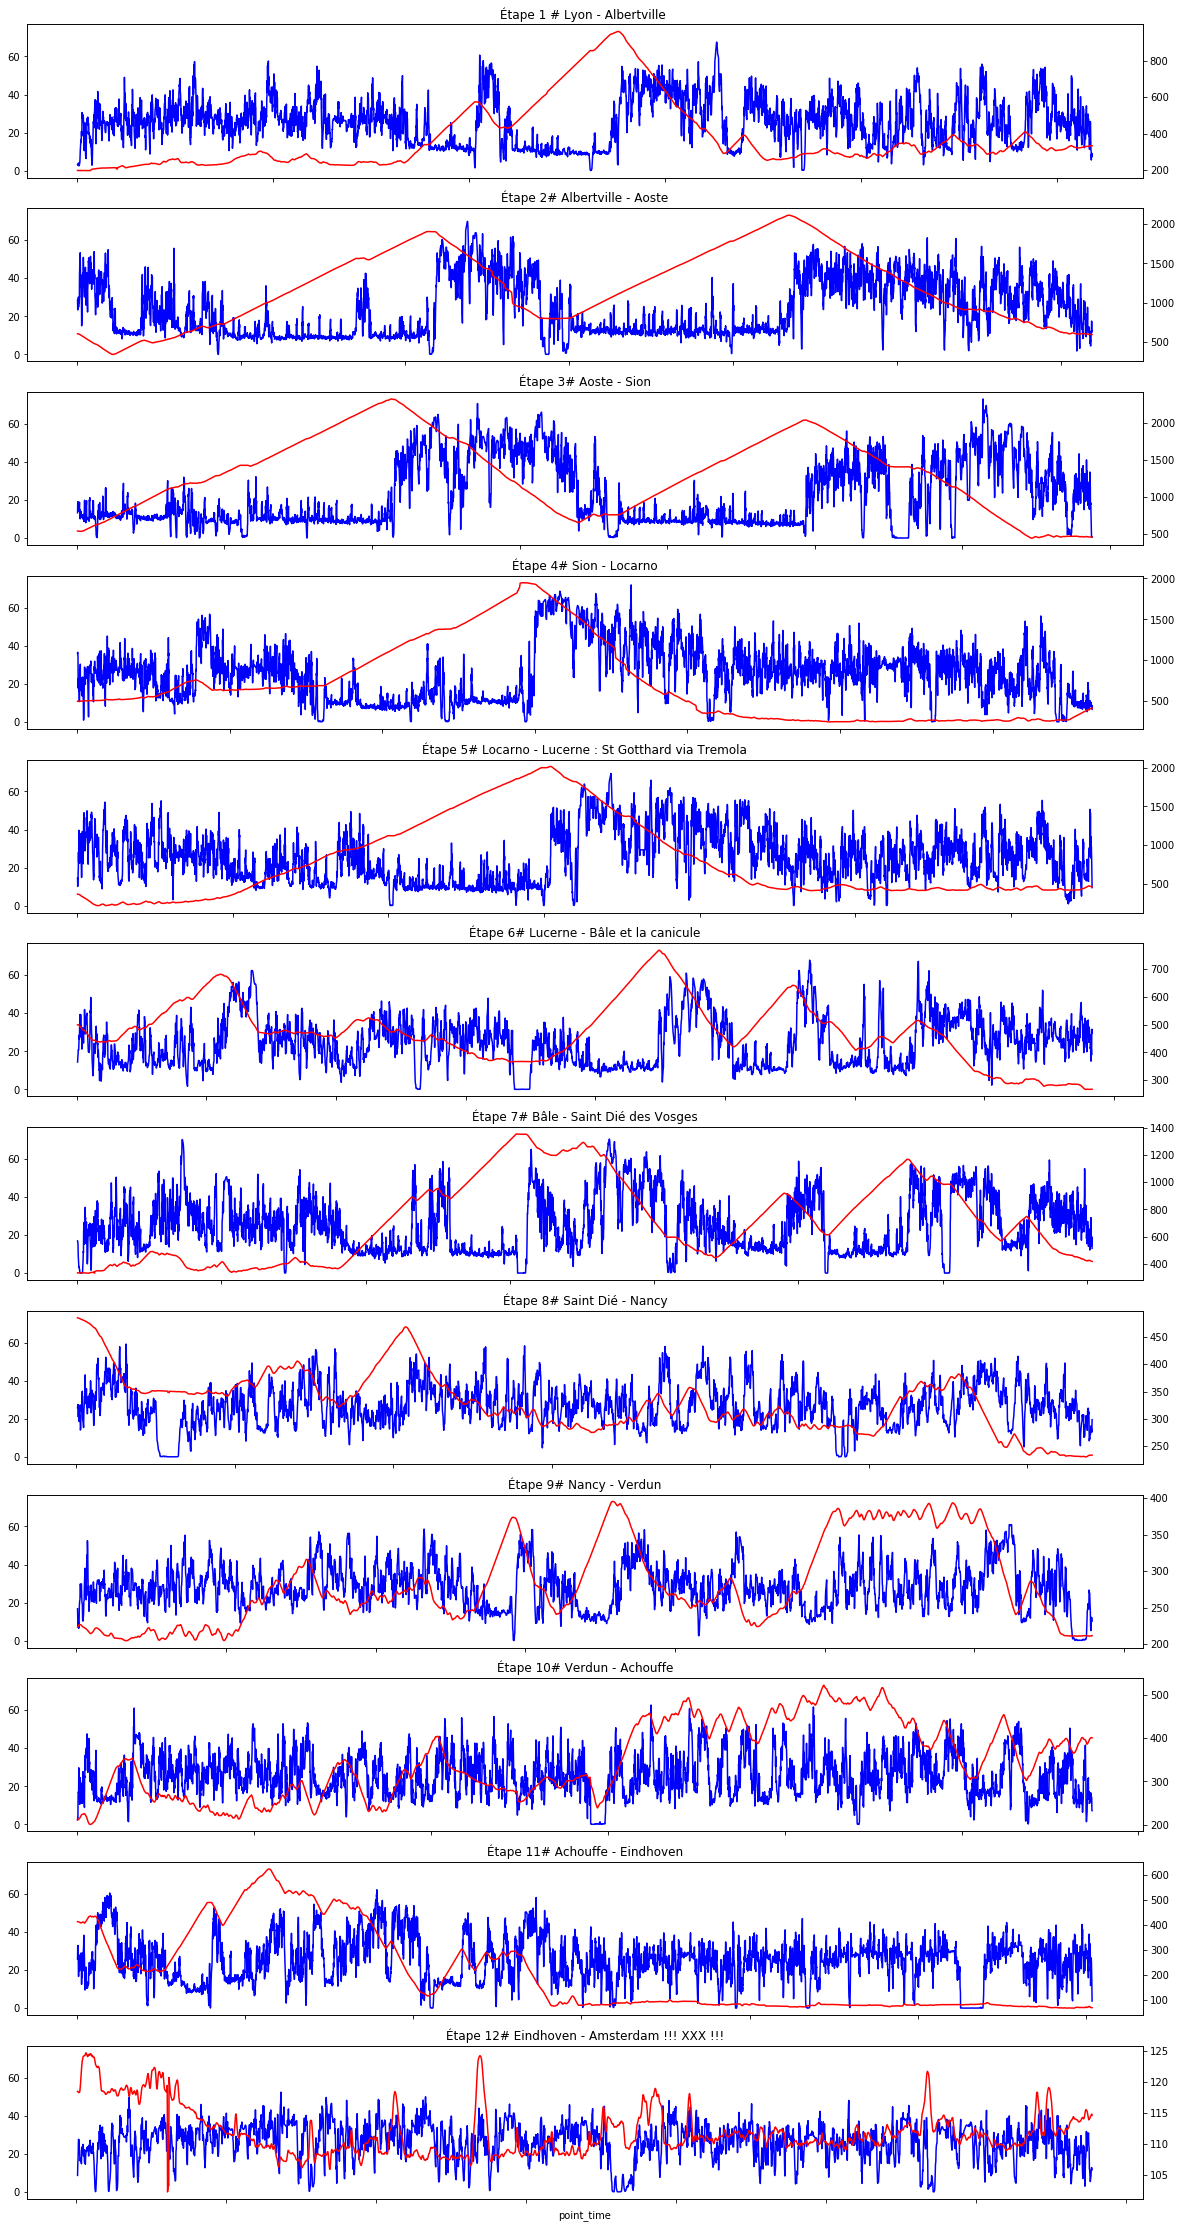

In [85]:
#https://github.com/matplotlib/matplotlib/issues/8392
etappe_index = np.arange(0,12).tolist()
etappes = df.etappe.unique().tolist()
df_dates = df.date.unique().tolist()

fig, ax = plt.subplots(len(df_dates), 1, figsize = [20,40], sharey='all')
ax= ax.flatten()
secondary_ax = []
for i, sub, title in list(zip(etappe_index, df_dates, etappes)):
    subdf = df.loc[df['date'] == sub, :]
    subdf['speed_kmh'].rolling(window=5).mean().plot(ax=ax[i], color='blue')
    secondary_ax.append(ax[i].twinx())
    subdf['elev'].rolling(window=5).mean().plot(ax=secondary_ax[i], color='red')
    ax[i].set_title(title)

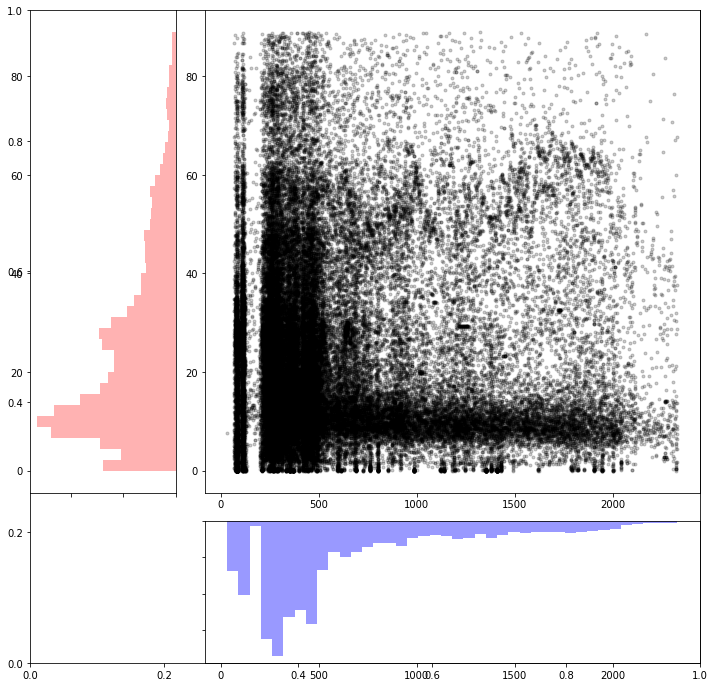

In [83]:
# https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.08-Multiple-Subplots.ipynb
y = df.speed_kmh.values
x = df.elev.values

# Set up the axes with gridspec
fig, ax = plt.subplots(figsize=(12, 12))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',orientation='vertical', 
            color='blue', alpha=.4)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', 
            color='red', alpha=.3)
y_hist.invert_xaxis()

## geo plots

In [69]:
#to geopandas
df_geo = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'})
df_geo['geometry'] = df_geo.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

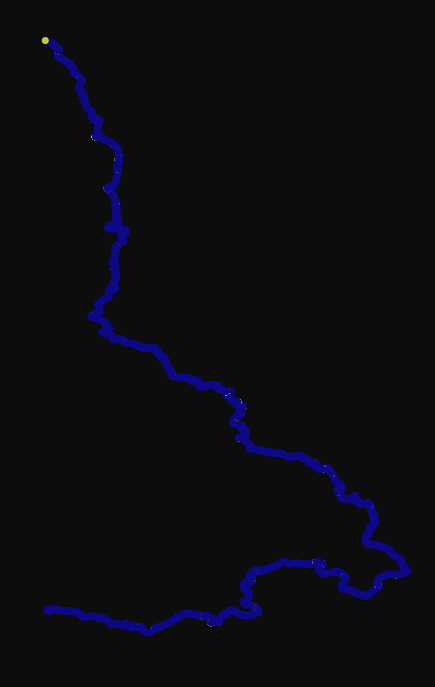

In [70]:
fig,ax = plt.subplots(figsize = [37,12], facecolor = '0.05')
#ax.set_aspect('equal')
ax.set_axis_off()
df_geo.plot(lw = 0.9, alpha = 0.8, ax=ax, column = 'mov', cmap ='plasma')